# Lleva a cabo la Validación del Modelo Entrenado con TF2 comparando contra los objetos indicados en los XMLs correspondientes
Se basa en propuesta de https://towardsdatascience.com/evaluating-performance-of-an-object-detection-model-137a349c517b

0) Preparar ambiente e instalar paquetes:

In [1]:
#@title Clonar el repositorio de modelos de TF si no está ya disponible
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [2]:
#@title Instalar el Object Detection API
# Nota: si dice que faltan librerías, ignorar (funciona bien igual) 
#       sino volverlo a ejecutar esta celda para que reinistale y entonces dice todo "successfully"
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1644507 sha256=76c164996fb20383ff7304df9adb7d280717c4cf0daf2ecc4fe1919a7d257089
  Stored in directory: /tmp/pip-ephem-wheel-cache-6h_15pxt/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=bf09527bc74aef51dfaea29f77816e9fee94a4fdcf91009a21332797dd30da39
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=ede7c50203c71aba2df217f259fd219b0c70ab1c55e2d42e4013dd43d82a91e2
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=61f4c8952ac2e33164167be7e436bca8ba4b5e050b735d181abc

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.28.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.



1) Cargar librerías:

In [3]:
#@title Cargar Librerías
import os
import os.path
import sys
import numpy as np
import pandas as pd
from random import sample

from IPython.display import Image, display
from PIL import Image as ImPIL

import tensorflow as tf
from PIL import ImageColor
from PIL import ImageDraw

import copy
import xml.etree.cElementTree as ET

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import time

print ("Librerías cargadas.")

Librerías cargadas.


2) Montar el Drive:

In [4]:
#@title Montar Google Drive
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
#@title Definir configuración de directorios local en Google Drive
model_drive_path = '/content/gdrive/MyDrive/IA/demoObjDet-Carteles-TF2/Carteles/TF_model' #@param {type:"string"}

data_dir_path = '/content/gdrive/MyDrive/IA/demoObjDet-Carteles/Carteles' #@param {type:"string"}

print("Configuración de archivos definida")

Configuración de archivos definida


3) Cargar el modelo entrenado:

In [6]:
#@title Cargar el modelo de object detection entrenado y define funciones auxiliares
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# carga el modelo exportado 
ModelObjDetEntrenado = model_drive_path + '/saved_model'
detection_model = tf.saved_model.load(str(ModelObjDetEntrenado))
print("\nModelo objDetector cargado: [", ModelObjDetEntrenado, "]: ", detection_model)

# archivo con lista de clases para reconocer 
labelMapFile = model_drive_path + '/label_map.pbtxt'

label_map = label_map_util.load_labelmap(labelMapFile)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)
print("\nDefinición de Clases cargada: [", labelMapFile, "]: ", len(category_index))

# Size, in inches, of the output images.
##IMAGE_SIZE = (12, 8)
##print("\nIMAGE SIZE: ",  IMAGE_SIZE)

## funciones auxiliares

# función auxiliar para conversión de la imagen ( NO SE USA )
#def load_image_into_numpy_array(image):
#    (im_width, im_height) = image.size
#    return np.array(image.getdata()).reshape(
#        (im_height, im_width, 3)).astype(np.uint8)

# función auxiliar para procesar la imagen con el modelo
def run_inference_for_single_image(model, image_np):   
    # fuerza conversión a array por las dudas
    image_np = np.asarray(image_np) 
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                  for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    # Handle models with masks:
    if 'detection_masks' in output_dict:
      # Reframe the the bbox mask to the image size.
      detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                output_dict['detection_masks'], output_dict['detection_boxes'],
                image.shape[0], image.shape[1])      
      detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                        tf.uint8)
      output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
      
    return output_dict

# función auxiliar para mostrar resultados de procesar la imagen con el modelo
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    line_thickness = 8,
                    min_score = 0.8):

    # genera una copia de la imagen
    image_np_with_annotations = image_np.copy()

    # en la copia marca los objetos detectados
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=100,
        line_thickness=line_thickness,
        min_score_thresh=min_score,
        agnostic_mode=False)
        
    # muestra la copia de la imagen con los objetos detectados
    display(ImPIL.fromarray(image_np_with_annotations))  
    #print("-- objetos detectados: ", len(classes), "\n")  # siempre son 300

print("\nFunciones Auxiliares definidas.")


Modelo objDetector cargado: [ /content/gdrive/MyDrive/IA/demoObjDet-Carteles-TF2/Carteles/TF_model/saved_model ]:  <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f4e4c445b90>

Definición de Clases cargada: [ /content/gdrive/MyDrive/IA/demoObjDet-Carteles-TF2/Carteles/TF_model/label_map.pbtxt ]:  2

Funciones Auxiliares definidas.


4) Llevar a cabo la validación usando las imágenes y XML:

In [7]:
#@title Definir funciones auxiliares 

# función para cálculo de Intersection over Union (IoU) 
def calc_IoU( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area


# función para mostrar boxes en una imagen dada
def draw_box(draw, rangeObj, lineWidth, lineColor):  

    draw.line([(rangeObj[0], rangeObj[1]), 
                        (rangeObj[0], rangeObj[3]), 
                        (rangeObj[2], rangeObj[3]), 
                        (rangeObj[2], rangeObj[1]), 
                        (rangeObj[0], rangeObj[1])], 
                      width=lineWidth, fill=lineColor)

# función para mostrar boxes de una lista objetos en una imagen dada
def draw_boxes_listObj(draw, listObj, lineWidth, lineColor):
  
    for obj in listObj:
        draw_box(draw, obj[2], lineWidth, lineColor)

# función para mostrar métricas de los resultados
def mostrarMetricas(metricas, titulo):

  print("\n= " + titulo + ":")        
  print("                  Modelo ")
  print(" XML   :       +          -   ")
  print("  +    :     %3d        %3d  " % (metricas[posVP], metricas[posFN]) )
  print("  -    :     %3d        %3d  " % (metricas[posFP], metricas[posVN]) )

  # Cálculo de la Exactitud
  total = (metricas[posVP] + metricas[posFP] + metricas[posVN] + metricas[posFN])
  if total>0:
      print("= Exactitud: ", round(100*(metricas[posVP] + metricas[posVN])/total, 3))

  # Cálculo de la Precisión
  total = (metricas[posVP] + metricas[posFP])
  if total>0:
      print("= Precisión: ",  round(100*metricas[posVP]/total,3))

  # Cálculo de la Recuperación
  total = (metricas[posVP] + metricas[posFN])
  if total>0:
      print("= Recuperación: ", round(100*metricas[posVP]/total,3))
  
  print("\n")
  return

print("Funciones auxiliares definidas")   

Funciones auxiliares definidas


In [8]:
#@title Definir imágenes a utilizar
# define la carpeta donde están las imágenes para procesar
imagenes_utilizar = '/validation' #@param [ '/validation', '/Generados' ]
if imagenes_utilizar == '/validation':
  dirTestImg = data_dir_path + '/validation/images' 
  dirTestXML = data_dir_path + '/validation/annotations' 
elif imagenes_utilizar == '/Generados':
  dirTestImg = data_dir_path + '/Generados'
  dirTestXML = data_dir_path + '/Generados'

# levanta los XML de validación para dirTestXML
process_FileNames = [ fn for fn in os.listdir( dirTestXML ) if fn.endswith('.xml') ]
print("> Imágenes/XML a probar: ", len(process_FileNames))

> Imágenes/XML a probar:  602


In [12]:
#@markdown ### Tomar una muestra de las imágenes (si es necesario o se quiere) { run: "auto" }
porcMuestraImagenesProcesar = 25  #@param {type:"slider", min:0, max:100, step:5}
if porcMuestraImagenesProcesar>0 and porcMuestraImagenesProcesar<100:
  cantProcesar = int(len(process_FileNames)*porcMuestraImagenesProcesar/100)
  if cantProcesar==0:
    cantProcesar = 1
  process_FileNames = sample(process_FileNames, cantProcesar)    
print("> Imágenes/XML a probar: ", len(process_FileNames))

> Imágenes/XML a probar:  75


In [13]:
#@title Definir parámetros a utilizar { run: "auto" }

# define minima probabilidad a usar
minimaProbabilidadObjectosDetectados = 95 #@param {type:"slider", min:1, max:100, step:1.0}
minProbObjDet = minimaProbabilidadObjectosDetectados / 100.

# define si muestra detalle o no
muestraDetalleDebug = False  #@param {type:"boolean"}
muestraDetalleObjDetectadosEnImagen = False  #@param {type:"boolean"}
muestraDetalleComparacionEnImagen = "Solo con Error" #@param ["Ninguna", "Solo con Error", "Todas"]
muestraDetalleMetricasPorImagen = "Solo con Error" #@param ["Ninguna", "Solo con Error", "Todas"]
muestraDetalleMetricasPorClaseObjeto = True  #@param {type:"boolean"}

# define parámetro Intersection over Union (IoU) 
## si calc_IoU(r1, r2) ≥ coefIoU, se considera que se detectó el objecto correctamente, es Verdadero Positivo (VP)
## si calc_IoU(r1, r2) < coefIoU, se considera que se detectó el objecto con error, es Falso Positivo (FP)
## -> valor recomendado por defecto: 0,5 
## pero se usa menos para mejorar los resultados
coefIoU = 0.4 #@param {type:"slider", min:0.1, max:1, step:0.1}

print("Parámetros definidos")

Parámetros definidos


> Parámetros: 
  minimaProbabilidadObjectosDetectados:  95
  coefIoU:  0.4


  muestraDetalleDebug:  False
  muestraDetalleObjDetectadosEnImagen:  False
  muestraDetalleComparacionEnImagen:  Solo con Error
  muestraDetalleMetricasPorImagen:  Solo con Error
  muestraDetalleMetricasPorClaseObjeto:  True





------------------------------------------------------------------------------------------------------------
< 1 >  cartel_401_MOWKIH7V8-c.xml : 


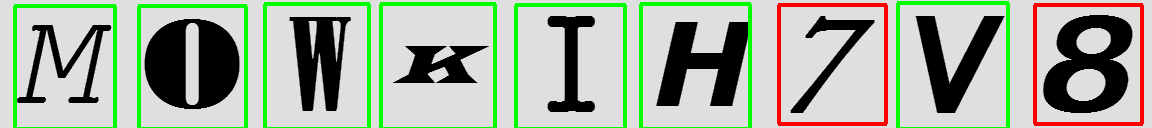

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       7          2  
  -    :       0          0  
= Exactitud:  77.778
= Precisión:  100.0
= Recuperación:  77.778



------------------------------------------------------------------------------------------------------------
< 2 >  cartel_46_HJ572KF6Q-c.xml : 


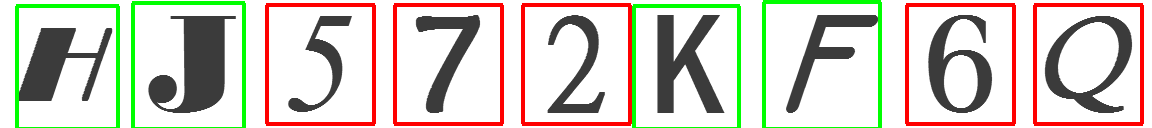

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       4          5  
  -    :       0          0  
= Exactitud:  44.444
= Precisión:  100.0
= Recuperación:  44.444



------------------------------------------------------------------------------------------------------------
< 3 >  cartel_231_W4-nsp.xml : 


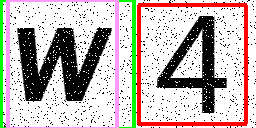

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       1          1  
  -    :       1          0  
= Exactitud:  33.333
= Precisión:  50.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 4 >  cartel_88_QOWD-c.xml : 


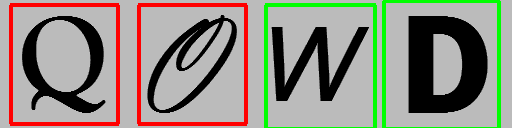

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          2  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 5 >  cartel_274_67SYPZ1LD-ng.xml : 


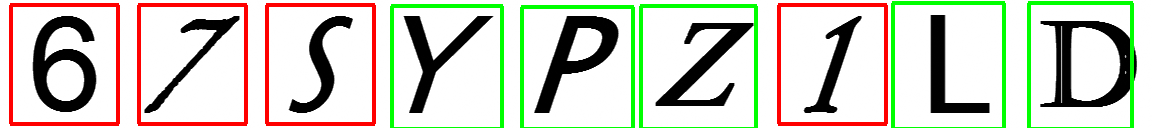

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       5          4  
  -    :       0          0  
= Exactitud:  55.556
= Precisión:  100.0
= Recuperación:  55.556



------------------------------------------------------------------------------------------------------------
< 6 >  cartel_161_MMV59K-nsp.xml : 


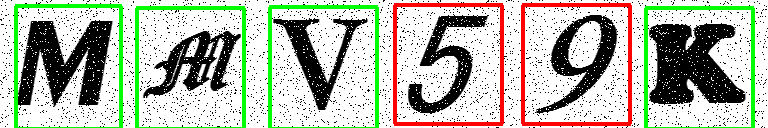

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       4          2  
  -    :       0          0  
= Exactitud:  66.667
= Precisión:  100.0
= Recuperación:  66.667



------------------------------------------------------------------------------------------------------------
< 7 >  cartel_59_MTNXHTGU8K-c.xml : 


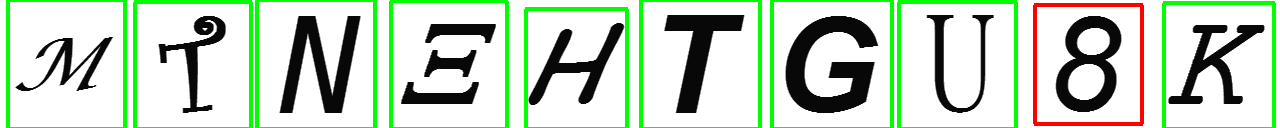

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       9          1  
  -    :       0          0  
= Exactitud:  90.0
= Precisión:  100.0
= Recuperación:  90.0



------------------------------------------------------------------------------------------------------------
< 8 >  cartel_323_1D-nsp.xml : 


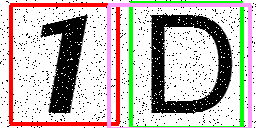

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       1          1  
  -    :       1          0  
= Exactitud:  33.333
= Precisión:  50.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 9 >  cartel_62_SVKT7KHT6.xml : 


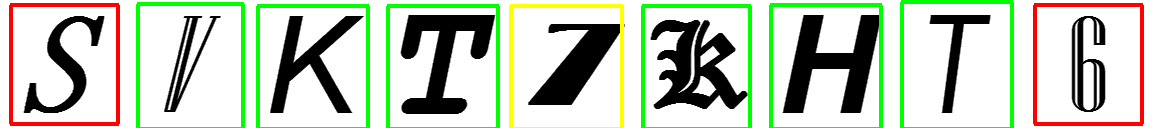

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       6          2  
  -    :       1          0  
= Exactitud:  66.667
= Precisión:  85.714
= Recuperación:  75.0



------------------------------------------------------------------------------------------------------------
< 10 >  cartel_388_G53.xml : 


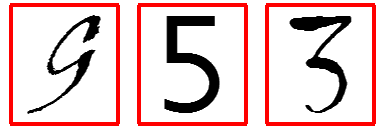

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       0          3  
  -    :       0          0  
= Exactitud:  0.0
= Recuperación:  0.0



------------------------------------------------------------------------------------------------------------
< 11 >  cartel_245_8TNBQ2E-ng.xml : 


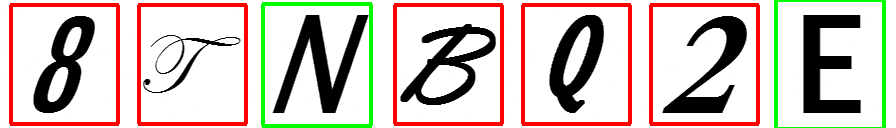

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          5  
  -    :       0          0  
= Exactitud:  28.571
= Precisión:  100.0
= Recuperación:  28.571



------------------------------------------------------------------------------------------------------------
< 12 >  cartel_161_MMV59K-c.xml : 


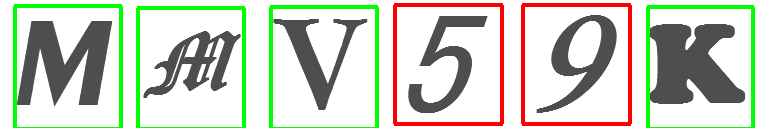

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       4          2  
  -    :       0          0  
= Exactitud:  66.667
= Precisión:  100.0
= Recuperación:  66.667



------------------------------------------------------------------------------------------------------------
< 13 >  cartel_104_7V6AM-c.xml : 


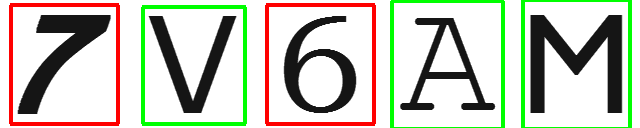

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       3          2  
  -    :       0          0  
= Exactitud:  60.0
= Precisión:  100.0
= Recuperación:  60.0



------------------------------------------------------------------------------------------------------------
< 14 >  cartel_439_SMWZH-ng.xml : 


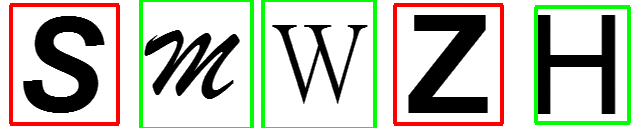

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       3          2  
  -    :       0          0  
= Exactitud:  60.0
= Precisión:  100.0
= Recuperación:  60.0



------------------------------------------------------------------------------------------------------------
< 15 >  cartel_303_XH1FU9N9F7-ng.xml : 


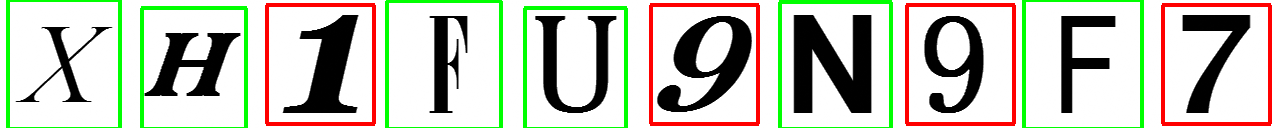

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       6          4  
  -    :       0          0  
= Exactitud:  60.0
= Precisión:  100.0
= Recuperación:  60.0



------------------------------------------------------------------------------------------------------------
< 16 >  cartel_241_A54H82GXKP-ng.xml : 


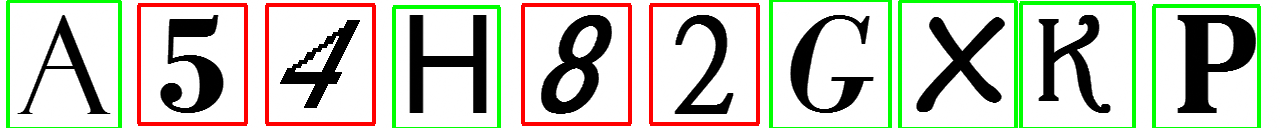

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       6          4  
  -    :       0          0  
= Exactitud:  60.0
= Precisión:  100.0
= Recuperación:  60.0



------------------------------------------------------------------------------------------------------------
< 17 >  cartel_424_3TY9ZO67X-ng.xml : 


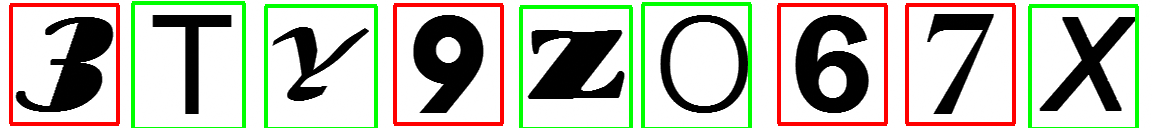

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       5          4  
  -    :       0          0  
= Exactitud:  55.556
= Precisión:  100.0
= Recuperación:  55.556



------------------------------------------------------------------------------------------------------------
< 18 >  cartel_386_QGF-nsp.xml : 


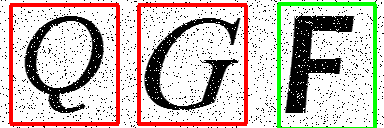

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       1          2  
  -    :       0          0  
= Exactitud:  33.333
= Precisión:  100.0
= Recuperación:  33.333



------------------------------------------------------------------------------------------------------------
< 19 >  cartel_47_1DM6W-ng.xml : 


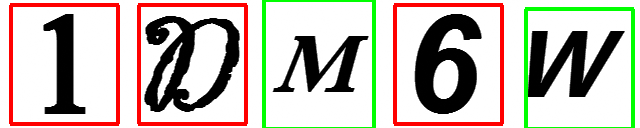

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          3  
  -    :       0          0  
= Exactitud:  40.0
= Precisión:  100.0
= Recuperación:  40.0



------------------------------------------------------------------------------------------------------------
< 20 >  cartel_179_DEG393O77-ng.xml : 


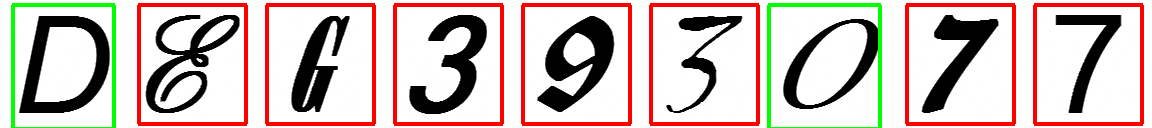

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          7  
  -    :       0          0  
= Exactitud:  22.222
= Precisión:  100.0
= Recuperación:  22.222



------------------------------------------------------------------------------------------------------------
< 21 >  cartel_37_5OWHP-c.xml : 


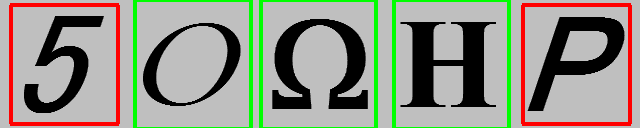

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       3          2  
  -    :       0          0  
= Exactitud:  60.0
= Precisión:  100.0
= Recuperación:  60.0



------------------------------------------------------------------------------------------------------------
< 22 >  cartel_86_79O.xml : 


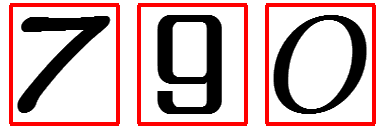

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       0          3  
  -    :       0          0  
= Exactitud:  0.0
= Recuperación:  0.0



------------------------------------------------------------------------------------------------------------
< 23 >  cartel_354_EVRR-ng.xml : 


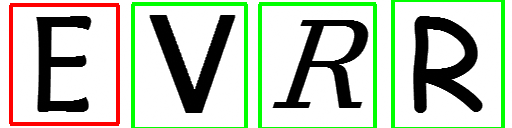

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       3          1  
  -    :       0          0  
= Exactitud:  75.0
= Precisión:  100.0
= Recuperación:  75.0



------------------------------------------------------------------------------------------------------------
< 24 >  cartel_289_831I29K-ng.xml : 


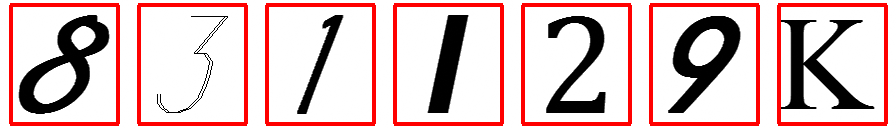

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       0          7  
  -    :       0          0  
= Exactitud:  0.0
= Recuperación:  0.0



------------------------------------------------------------------------------------------------------------
< 25 >  cartel_332_NS-ng.xml : 


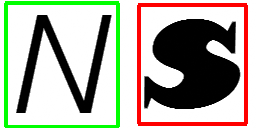

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       1          1  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 26 >  cartel_295_DF9RXW-c.xml : 


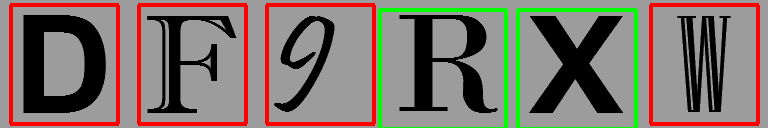

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          4  
  -    :       0          0  
= Exactitud:  33.333
= Precisión:  100.0
= Recuperación:  33.333



------------------------------------------------------------------------------------------------------------
< 27 >  cartel_51_BMDR1G4.xml : 


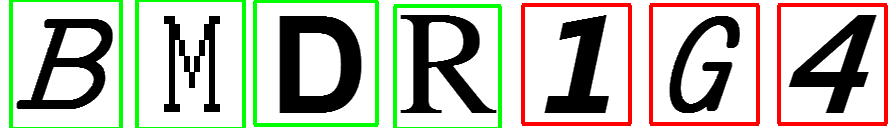

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       4          3  
  -    :       0          0  
= Exactitud:  57.143
= Precisión:  100.0
= Recuperación:  57.143



------------------------------------------------------------------------------------------------------------
< 28 >  cartel_89_WTWKAH-nsp.xml : 


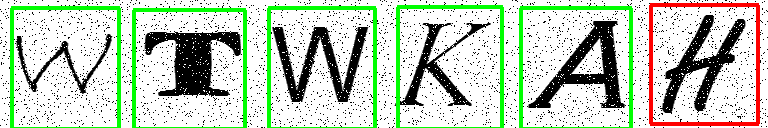

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       5          1  
  -    :       0          0  
= Exactitud:  83.333
= Precisión:  100.0
= Recuperación:  83.333



------------------------------------------------------------------------------------------------------------
< 29 >  cartel_202_3P84UX.xml : 


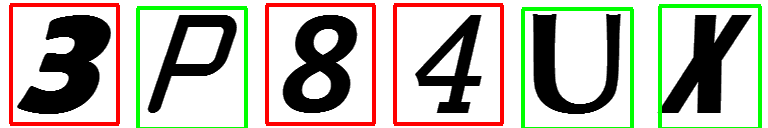

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       3          3  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 30 >  cartel_232_AUPI55I-c.xml : 


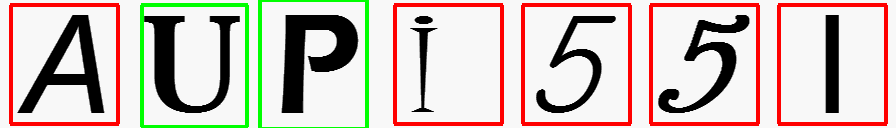

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          5  
  -    :       0          0  
= Exactitud:  28.571
= Precisión:  100.0
= Recuperación:  28.571



------------------------------------------------------------------------------------------------------------
< 31 >  cartel_394_HYAP-ng.xml : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 32 >  cartel_488_MGBW1Y-ng.xml : 


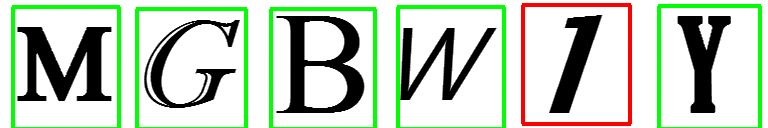

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       5          1  
  -    :       0          0  
= Exactitud:  83.333
= Precisión:  100.0
= Recuperación:  83.333



------------------------------------------------------------------------------------------------------------
< 33 >  cartel_352_RKO0.xml : 


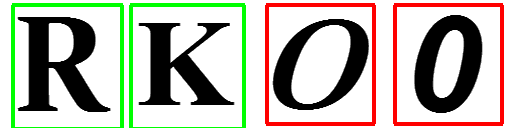

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          2  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 34 >  cartel_174_W5EJ-nsp.xml : 


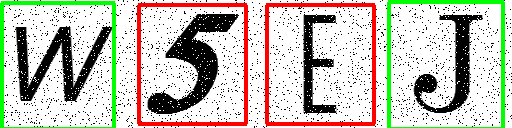

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          2  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 35 >  cartel_178_3QFC4B1N3M.xml : 


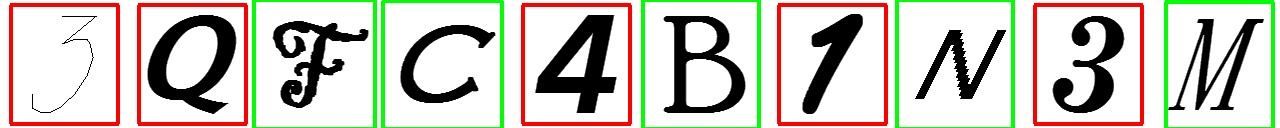

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       5          5  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 36 >  cartel_169_MR-ng.xml : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 37 >  cartel_16_RULX35QCRI.xml : 


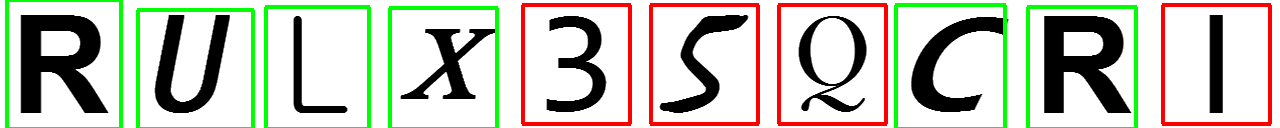

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       6          4  
  -    :       0          0  
= Exactitud:  60.0
= Precisión:  100.0
= Recuperación:  60.0



------------------------------------------------------------------------------------------------------------
< 38 >  cartel_13_MLSVIM-ng.xml : 


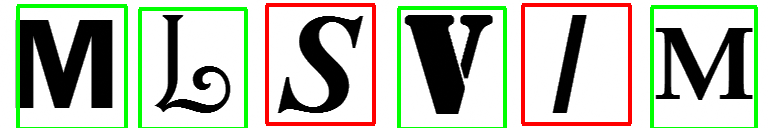

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       4          2  
  -    :       0          0  
= Exactitud:  66.667
= Precisión:  100.0
= Recuperación:  66.667



------------------------------------------------------------------------------------------------------------
< 39 >  cartel_415_N09KNICY.xml : 


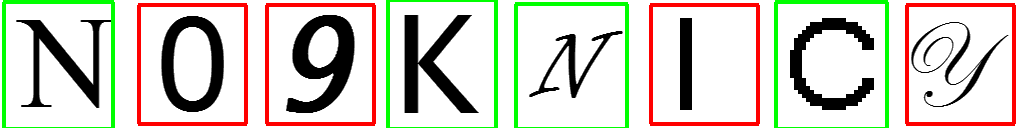

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       4          4  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 40 >  cartel_294_DB-c.xml : 


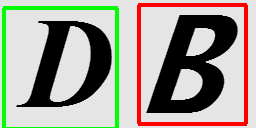

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       1          1  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 41 >  cartel_14_YZD418-ng.xml : 


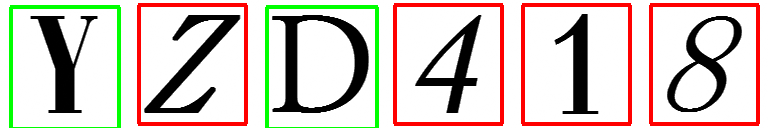

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          4  
  -    :       0          0  
= Exactitud:  33.333
= Precisión:  100.0
= Recuperación:  33.333



------------------------------------------------------------------------------------------------------------
< 42 >  cartel_337_69U1N171-c.xml : 


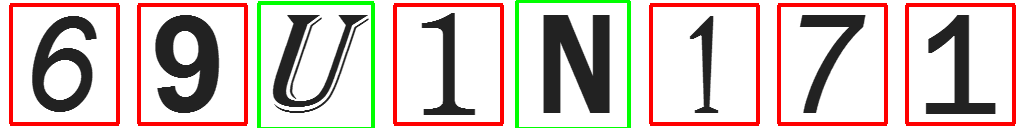

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          6  
  -    :       0          0  
= Exactitud:  25.0
= Precisión:  100.0
= Recuperación:  25.0



------------------------------------------------------------------------------------------------------------
< 43 >  cartel_340_MJBD3507R-nsp.xml : 


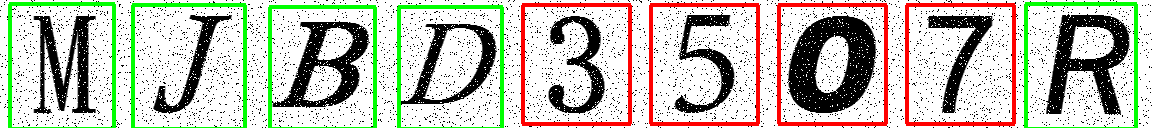

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       5          4  
  -    :       0          0  
= Exactitud:  55.556
= Precisión:  100.0
= Recuperación:  55.556



------------------------------------------------------------------------------------------------------------
< 44 >  cartel_248_WPB7TG1-nsp.xml : 


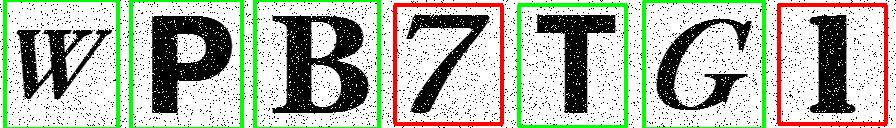

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       5          2  
  -    :       0          0  
= Exactitud:  71.429
= Precisión:  100.0
= Recuperación:  71.429



------------------------------------------------------------------------------------------------------------
< 45 >  cartel_313_B4OP.xml : 


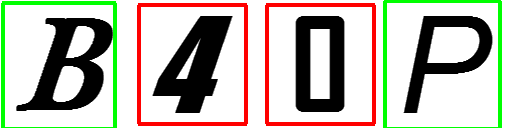

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          2  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 46 >  cartel_153_HYDEXV5-nsp.xml : 


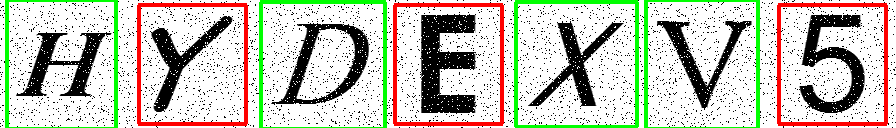

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       4          3  
  -    :       0          0  
= Exactitud:  57.143
= Precisión:  100.0
= Recuperación:  57.143



------------------------------------------------------------------------------------------------------------
< 47 >  cartel_244_LU7AQDHVW-c.xml : 


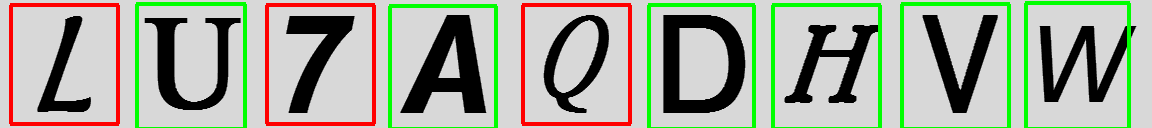

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       6          3  
  -    :       0          0  
= Exactitud:  66.667
= Precisión:  100.0
= Recuperación:  66.667



------------------------------------------------------------------------------------------------------------
< 48 >  cartel_122_GBSQIK7FT.xml : 


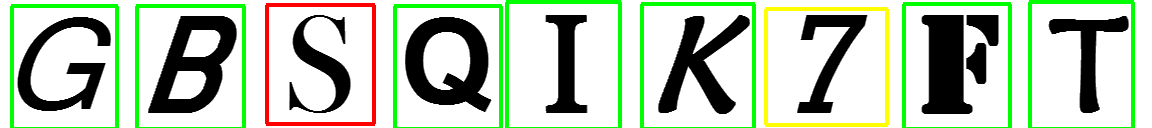

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       7          1  
  -    :       1          0  
= Exactitud:  77.778
= Precisión:  87.5
= Recuperación:  87.5



------------------------------------------------------------------------------------------------------------
< 49 >  cartel_151_H9EI5ZIF-c.xml : 


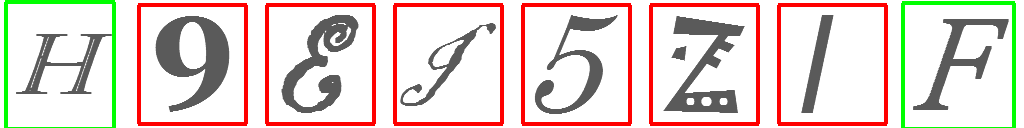

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          6  
  -    :       0          0  
= Exactitud:  25.0
= Precisión:  100.0
= Recuperación:  25.0



------------------------------------------------------------------------------------------------------------
< 50 >  cartel_204_416CU-nsp.xml : 


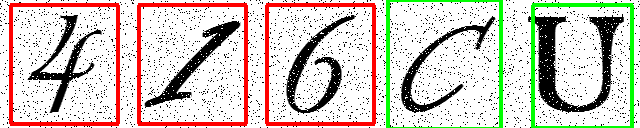

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          3  
  -    :       0          0  
= Exactitud:  40.0
= Precisión:  100.0
= Recuperación:  40.0



------------------------------------------------------------------------------------------------------------
< 51 >  cartel_290_DF3SMVBC-ng.xml : 


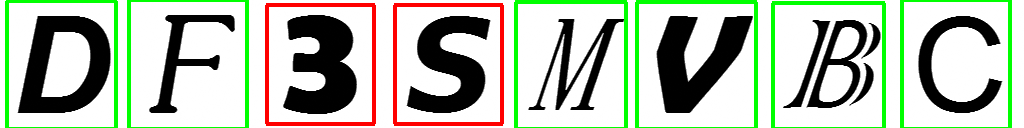

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       6          2  
  -    :       0          0  
= Exactitud:  75.0
= Precisión:  100.0
= Recuperación:  75.0



------------------------------------------------------------------------------------------------------------
< 52 >  cartel_181_GPEKTZXD-nsp.xml : 


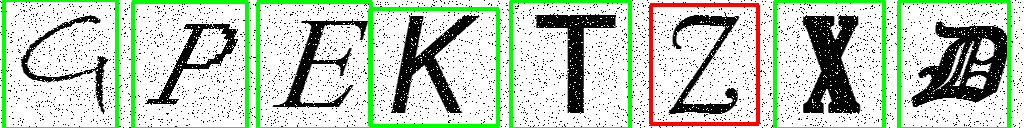

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       7          1  
  -    :       0          0  
= Exactitud:  87.5
= Precisión:  100.0
= Recuperación:  87.5



------------------------------------------------------------------------------------------------------------
< 53 >  cartel_221_K7VDQTA-ng.xml : 


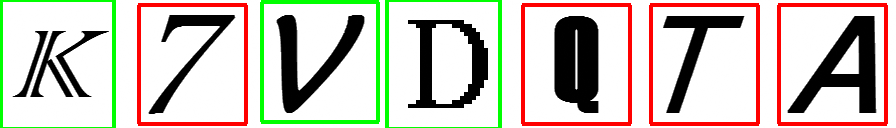

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       3          4  
  -    :       0          0  
= Exactitud:  42.857
= Precisión:  100.0
= Recuperación:  42.857



------------------------------------------------------------------------------------------------------------
< 54 >  cartel_40_T8WTELPEXG-c.xml : 


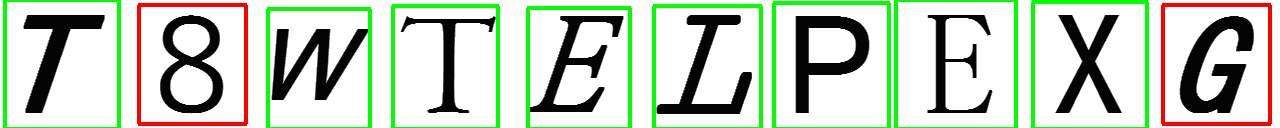

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       8          2  
  -    :       0          0  
= Exactitud:  80.0
= Precisión:  100.0
= Recuperación:  80.0



------------------------------------------------------------------------------------------------------------
< 55 >  cartel_164_WUV8O1-c.xml : 


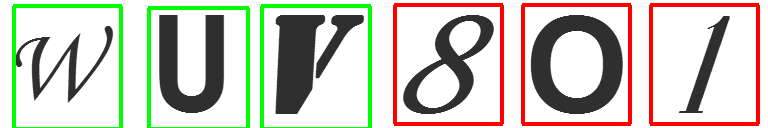

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       3          3  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 56 >  cartel_281_B93B.xml : 


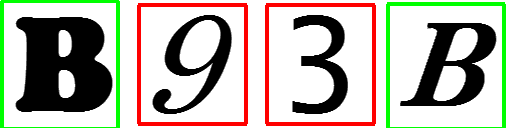

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          2  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 57 >  cartel_312_A1331RN-c.xml : 


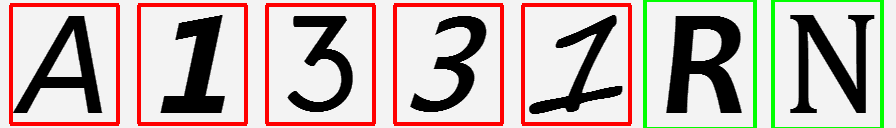

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          5  
  -    :       0          0  
= Exactitud:  28.571
= Precisión:  100.0
= Recuperación:  28.571



------------------------------------------------------------------------------------------------------------
< 58 >  cartel_299_0U8G-c.xml : 


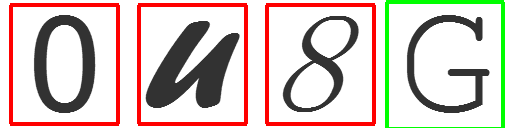

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       1          3  
  -    :       0          0  
= Exactitud:  25.0
= Precisión:  100.0
= Recuperación:  25.0



------------------------------------------------------------------------------------------------------------
< 59 >  cartel_211_MG01RL-c.xml : 


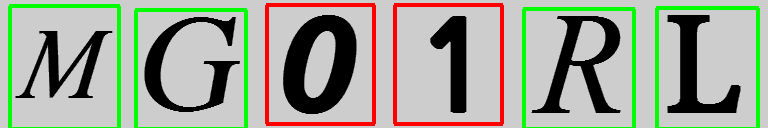

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       4          2  
  -    :       0          0  
= Exactitud:  66.667
= Precisión:  100.0
= Recuperación:  66.667



------------------------------------------------------------------------------------------------------------
< 60 >  cartel_343_X1OLU5UV.xml : 


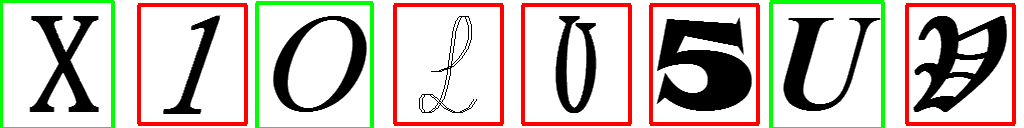

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       3          5  
  -    :       0          0  
= Exactitud:  37.5
= Precisión:  100.0
= Recuperación:  37.5



------------------------------------------------------------------------------------------------------------
< 61 >  cartel_109_4KOH-nsp.xml : 


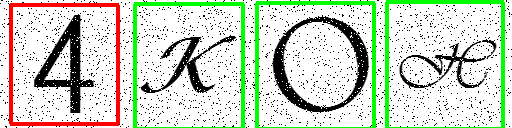

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       3          1  
  -    :       0          0  
= Exactitud:  75.0
= Precisión:  100.0
= Recuperación:  75.0



------------------------------------------------------------------------------------------------------------
< 62 >  cartel_30_232V.xml : 


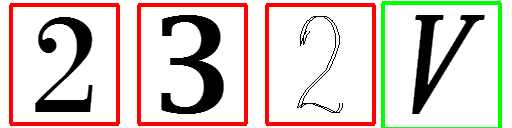

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       1          3  
  -    :       0          0  
= Exactitud:  25.0
= Precisión:  100.0
= Recuperación:  25.0



------------------------------------------------------------------------------------------------------------
< 63 >  cartel_309_UVMFW3QR-nsp.xml : 


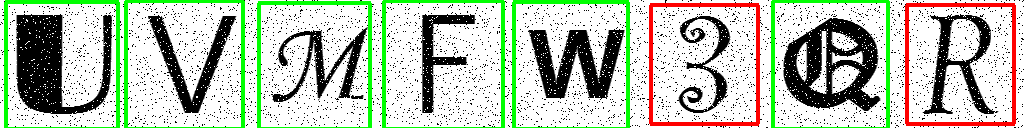

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       6          2  
  -    :       0          0  
= Exactitud:  75.0
= Precisión:  100.0
= Recuperación:  75.0



------------------------------------------------------------------------------------------------------------
< 64 >  cartel_267_JFOXCRUS8L-ng.xml : 


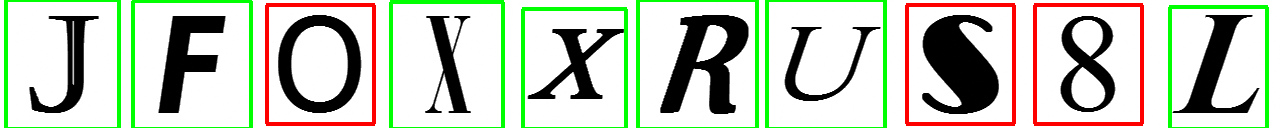

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       7          3  
  -    :       0          0  
= Exactitud:  70.0
= Precisión:  100.0
= Recuperación:  70.0



------------------------------------------------------------------------------------------------------------
< 65 >  cartel_105_7HW5AK-c.xml : 


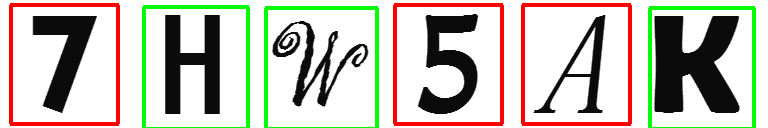

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       3          3  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 66 >  cartel_465_86B1C4F-c.xml : 


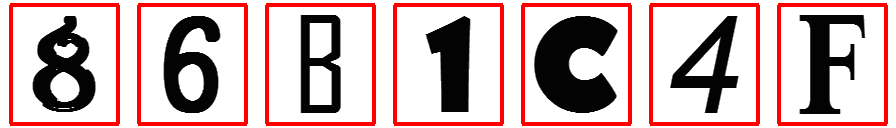

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       0          7  
  -    :       0          0  
= Exactitud:  0.0
= Recuperación:  0.0



------------------------------------------------------------------------------------------------------------
< 67 >  cartel_370_W5HYMQ.xml : 


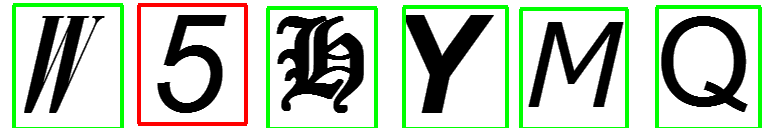

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       5          1  
  -    :       0          0  
= Exactitud:  83.333
= Precisión:  100.0
= Recuperación:  83.333



------------------------------------------------------------------------------------------------------------
< 68 >  cartel_423_LZQUU-c.xml : 


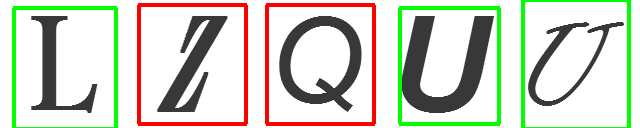

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       3          2  
  -    :       0          0  
= Exactitud:  60.0
= Precisión:  100.0
= Recuperación:  60.0



------------------------------------------------------------------------------------------------------------
< 69 >  cartel_420_JNMX3TGOE-c.xml : 


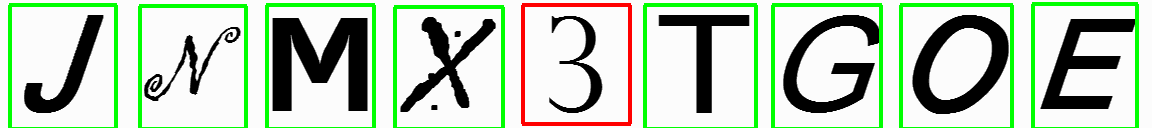

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       8          1  
  -    :       0          0  
= Exactitud:  88.889
= Precisión:  100.0
= Recuperación:  88.889



------------------------------------------------------------------------------------------------------------
< 70 >  cartel_357_D778WB52Z-ng.xml : 


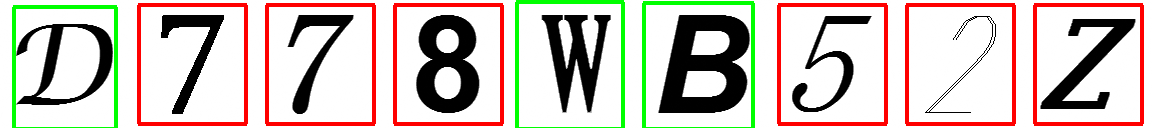

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       3          6  
  -    :       0          0  
= Exactitud:  33.333
= Precisión:  100.0
= Recuperación:  33.333



------------------------------------------------------------------------------------------------------------
< 71 >  cartel_23_RMZ7C6CC-c.xml : 


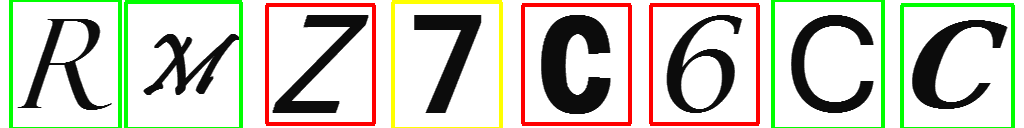

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       4          3  
  -    :       1          0  
= Exactitud:  50.0
= Precisión:  80.0
= Recuperación:  57.143



------------------------------------------------------------------------------------------------------------
< 72 >  cartel_78_DSAKJ.xml : 


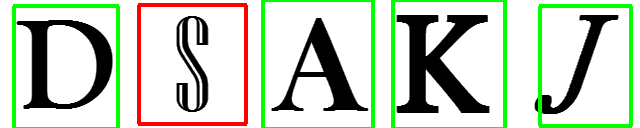

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       4          1  
  -    :       0          0  
= Exactitud:  80.0
= Precisión:  100.0
= Recuperación:  80.0



------------------------------------------------------------------------------------------------------------
< 73 >  cartel_109_4KOH-ng.xml : 


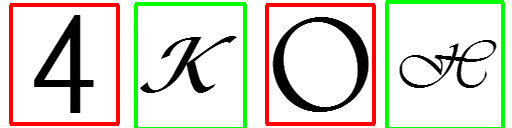

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       2          2  
  -    :       0          0  
= Exactitud:  50.0
= Precisión:  100.0
= Recuperación:  50.0



------------------------------------------------------------------------------------------------------------
< 74 >  cartel_363_V9-c.xml : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 75 >  cartel_171_S0T10POFPD.xml : 


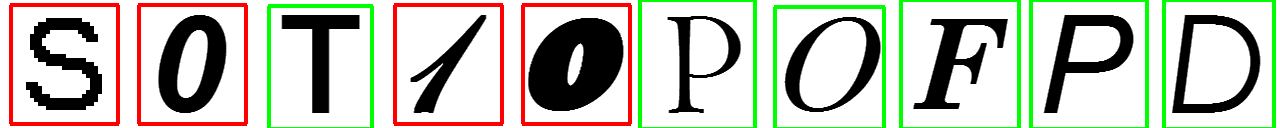

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

= Matriz de Confusión para la Imagen:
                  Modelo 
 XML   :       +          -   
  +    :       6          4  
  -    :       0          0  
= Exactitud:  60.0
= Precisión:  100.0
= Recuperación:  60.0



 == VALIDACIÓN FINALIZADA ==
 XMLs revisados:  75

  72  XMLs con problemas detectados: 
	 [ 'cartel_401_MOWKIH7V8-c.xml', 'cartel_46_HJ572KF6Q-c.xml', 'cartel_231_W4-nsp.xml', 'cartel_88_QOWD-c.xml', 'cartel_274_67SYPZ1LD-ng.xml', 'cartel_161_MMV59K-nsp.xml', 'cartel_59_MTNXHTGU8K-c.xml', 'cartel_323_1D-nsp.xml', 'cartel_62_SVKT7KHT6.xml', 'cartel_388_G53.xml', 'cartel_245_8TNBQ2E-

In [14]:
#@title Realizar el Procesamiento de las Imágenes comparando contra XMLs

# inicializa vector auxiliar para metricas y posiciones a usar
listaXMLConProblemas = []
cantXMLProcesados = 0
metricasGral = [ 0, 0, 0, 0]
posVP = 0
posVN = 1
posFP = 2
posFN = 3

# inicializa diccionario auxiliar para metricas por tipo de caso generado
metricasGral_porTipoCaso = {}

# inicializa vectores auxiliares para evaluación de objetos detectados
classObjModelo = []
classObjReal = []

# auxiliar para calcular tiempos del modelo
auxSumaTiempo = 0
auxCantProc = 0

# muestra parámetros
print("> Parámetros: ")
print("  minimaProbabilidadObjectosDetectados: ", minimaProbabilidadObjectosDetectados)
print("  coefIoU: ", coefIoU)
print("\n")
print("  muestraDetalleDebug: ", muestraDetalleDebug)
print("  muestraDetalleObjDetectadosEnImagen: ", muestraDetalleObjDetectadosEnImagen)
print("  muestraDetalleComparacionEnImagen: ", muestraDetalleComparacionEnImagen)
print("  muestraDetalleMetricasPorImagen: ", muestraDetalleMetricasPorImagen)
print("  muestraDetalleMetricasPorClaseObjeto: ", muestraDetalleMetricasPorClaseObjeto)
print("\n\n\n")

# Procesa los XMLs de las imágenes 
for xml_file in process_FileNames:

    # inicializa vectores auxiliares
    listObjsXML = []
    listObjsDetModelo = []
    
    print("\n------------------------------------------------------------------------------------------------------------")
    cantXMLProcesados = cantXMLProcesados + 1
    print("<", cantXMLProcesados, "> ", xml_file, ": ")

    # determina el tipo de archivo
    tipoCaso = ""
    if xml_file.startswith("da_"):
      tipoCaso = "DA"
    else:
      tipoCaso = "OR"
    if xml_file.find("r-")>=0 or xml_file.find("r.")>=0:
      tipoCaso = tipoCaso + '_R'
    elif xml_file.find("s-")>=0 or xml_file.find("s.")>=0:
      tipoCaso = tipoCaso + '_S'
    else:
      tipoCaso = tipoCaso + '_N'

    # carga la info del XML original
    et = ET.parse(dirTestXML + '/' + xml_file)
    element = et.getroot()
    element_objs = element.findall('object') 
    element_filename = element.find('filename').text

    imagenProcesar = os.path.join(dirTestImg, element_filename)

    # controla que exista la imagen
    if not os.path.isfile(imagenProcesar):
      print("\t -- No se encuentra la imagen ", imagenProcesar, "!\n")
      # deja de procesar el XML y pasa al siguiente
      continue

    # carga los elementos en el archivo XML original para generar el nuevo
    for element_obj in element_objs:

        # obtiene la información actual de la imagen
        class_name = element_obj.find('name').text 

        # obtiene info del box actual
        obj_bbox = element_obj.find('bndbox')
        nuevoRangoIm = [ float(obj_bbox.find('xmin').text),
                        float(obj_bbox.find('ymin').text),
                        float(obj_bbox.find('xmax').text), 
                        float(obj_bbox.find('ymax').text) ]

        # si tiene invertidas las posiciones las corrige
        if nuevoRangoIm[0] > nuevoRangoIm[2]:
          auxnuevoRangoIm = nuevoRangoIm[2]
          nuevoRangoIm[2] = nuevoRangoIm[0]
          nuevoRangoIm[0] = auxnuevoRangoIm
        if nuevoRangoIm[1] > nuevoRangoIm[3]:
          auxnuevoRangoIm = nuevoRangoIm[3]
          nuevoRangoIm[3] = nuevoRangoIm[1]
          nuevoRangoIm[1] = auxnuevoRangoIm

        # calcula un valor para poder ordenar las figuras de arriba a abajo y izquierda a derecha
        centroideIm = nuevoRangoIm[1]*100000+nuevoRangoIm[0]

        # agrega a lista de objetos cargados del XML
        # controlando que no estuviera ya (para evitar duplicados)
        elObjXML = (centroideIm, class_name, nuevoRangoIm)        
        if elObjXML not in listObjsXML:
          listObjsXML.append( elObjXML )

      # carga la imagen a procesar
    imageCargada = ImPIL.open(imagenProcesar) 

    # Convierte la imagen a escala de grises y luego a RGB 
    # (para sacarle los colores que tuviera previamente y dejarlo con 3 canales de profundidad)
    imageCargada = imageCargada.convert('L')
    imageCargada = imageCargada.convert('RGB')

    # obtiene el tamaño de la imagen
    imCargada_ancho, imCargada_alto = imageCargada.size

    # convierte la imagen a un array 
    image_np = np.array(imageCargada)

    # Procesa el array de la imagen con el modelo cargado
    tiempoInicioModelo = time.time()
    output_dict = run_inference_for_single_image(detection_model, image_np)
    tiempoDemoraModelo = (time.time() - tiempoInicioModelo)
    if muestraDetalleDebug:
        print("\n# Ejecutar el modelo demora ", tiempoDemoraModelo, " segundos. \n")
    auxSumaTiempo = auxSumaTiempo  + tiempoDemoraModelo
    auxCantProc = auxCantProc  + 1

    # procesa los objetos detectados
    for detClass, detBox, detScore in zip(  output_dict['detection_classes'], output_dict['detection_boxes'], output_dict['detection_scores'] ):

        class_name = category_index[detClass]['name']

        # como las coordenadas están normalizadas las debe convertir 
        # teniendo en cuenta el tamaño de la imagen
        # además notar que vienen datas en otro orden
        # - detBox = (ini alto, ini ancho, fin alto, fin ancho)
        # - nuevoRangoIn = (ini ancho x1, ini alto y1, fin ancho x2, fin alto y2)    
        nuevoRangoIm = [detBox[1] * imCargada_ancho, 
                        detBox[0] * imCargada_alto,
                        detBox[3] * imCargada_ancho,
                        detBox[2] * imCargada_alto]

        # si el objeto detectado tiene un puntaje superior o igual al mínimo
        if detScore >= minProbObjDet:

              # calcula un valor para poder ordenar las figuras de arriba a abajo y izquierda a derecha
              centroideIm = nuevoRangoIm[1]*100000+nuevoRangoIm[0]

              # agrega a lista de objetos detectados por el modelo
              listObjsDetModelo.append( (centroideIm, class_name, nuevoRangoIm) )          
        else:
              if muestraDetalleDebug and detScore >= 0.4:
                print("-- Objeto descartado por bajo score: ", class_name, "(", detScore*100, "%) en ", nuevoRangoIm)

    # ordena por el centroide las dos listas
    listObjsXML = sorted(listObjsXML, key=lambda objDet: objDet[0])  
    listObjsDetModelo = sorted(listObjsDetModelo, key=lambda objDet: objDet[0])  

    if muestraDetalleDebug:
        print("\n- Objetos del XML:")
        print(len(listObjsXML), " : ",listObjsXML)

        print("\n- Objetos detectados por el Modelo:")
        print(len(listObjsDetModelo), " : ", listObjsDetModelo)

    if muestraDetalleObjDetectadosEnImagen: 

        print("\n- Muestra los objetos del XML y Detectados en la Imagen:")
        # imagen auxiliar para mostrar recuadros de XML y modelo
        image_pil = copy.deepcopy(imageCargada.convert("RGB"))
        draw = ImageDraw.Draw(image_pil)
        im_width, im_height = image_pil.size    

        # genera los recuadros correspondientes del XML (en color verde)
        draw_boxes_listObj(draw, listObjsXML, 8, (0,255,0))
            
        # genera los recuadros correspondientes al Modelo (en color azul)
        draw_boxes_listObj(draw, listObjsDetModelo, 4, (0,0,255))

        imMostrar = ImPIL.fromarray(np.array(image_pil), 'RGB')
        display( imMostrar )
        print(" Nota colores:")
        print("    Objetos definidos en el XML, cuadros en VERDE.")
        print("    Objetos detectados por el Modelo, cuadros en AZUL.")
        print("\n")

    # Realiza la compración de los objetos definidos en el XML contra los detectados por el modelo
    if muestraDetalleDebug:
        print("\n+ Realiza la Comparación: ")

    resCompara = []
    auxlistObjsDetModelo = copy.copy(listObjsDetModelo)

    # Busca el objeto del XML en la lista de objetos detectados por el Modelo
    # (para eso considera la ubicación y tipo de clase)
    for objXML in listObjsXML:
        i = -1
        noEnc = True
        while noEnc and i < (len(auxlistObjsDetModelo)-1):         
          i = i + 1
          
          # calcula la Intersection over Union (IoU) de los boxes
          objIoU = calc_IoU( objXML[2], auxlistObjsDetModelo[i][2] )

          # si el IoU es casi perfecto, considera que es el objeto
          #if objIoU > 0.90: 
          #  noEnc = False
          #else:
           #  analiza si tiene algo de superposición y es de la misma clase
          noEnc = not((objIoU > 0.1) and (objXML[1] == auxlistObjsDetModelo[i][1]))

        if noEnc:

           # Si no se encuentra objeto con misma ubicación y clase del XML
          if muestraDetalleDebug:
              print(objXML[1], " no detectado por el Modelo con misma ubicación y clase ")

          # registra que ese objeto no se encontró
          resCompara.append(  (objXML[1], -1, objXML[2], "*") )

        else:

          # Si encuentra objecto en misma ubicación y  clase del XML
          if muestraDetalleDebug:
              print(objXML[1], ": ", objIoU)

          # regista que el objeto se encontró con su IoU
          resCompara.append(  (objXML[1], objIoU, auxlistObjsDetModelo[i][2], auxlistObjsDetModelo[i][1]) )

          # saca el objeto de la lista auxiliar para que no se vuelva a usar
          auxlistObjsDetModelo.pop(i)

    # Revisa los objetos detectados que no se utilizaron en la comparación anterior
    # para incluir en la comparación  
    #  objetos en la misma ubicación pero  con distinta clase
    #   u objetos detectados que no figuran en el XML
    if len(auxlistObjsDetModelo) > 0:
      if muestraDetalleDebug:
        print("\n-Se intenta asociar con ", len(auxlistObjsDetModelo), " objetos detectados del Modelo no utilizados")

      for objDet in auxlistObjsDetModelo:

        # lo compara con los que no se puedieron detectar
        i = 0
        cont = True
        while cont and i < len(resCompara):

            # sólo procesa es un objeto del XML no encontrado en Modelo 
            if (resCompara[i][1] < 0):
                # calcula la Intersection over Union (IoU) de los boxes
                objIoU = calc_IoU( resCompara[i][2], objDet[2] )

                if objIoU >= coefIoU:
                      # si están superpuestos se considera que se detectó pero le asignó mal la clase                    
                      resCompara[i] = (resCompara[i][0], objIoU, objDet[2], objDet[1] )                   
                      cont = False

                      if muestraDetalleDebug:
                          print("--- Se rectifica objeto no detectado: ", resCompara[i])
            i = i + 1

        if cont:
          # si no se utiliza, se agrega como objeto detectado de más
          resCompara.append(  ("*", 999, objDet[2], objDet[1]) )

          if muestraDetalleDebug:
              print("--- Se agrega objeto detectado por Modelo de más: ", objDet[1])

    if muestraDetalleDebug:

        print("\n+ Resultados de la Comparación:")
        print( len(resCompara), " : ", resCompara )


    # Realiza el cálculo de las Métricas de la Imagen considerando los resultados de la comparación
    ## ---------------------------------------------------------------------------------------------
    ## Nota los Verdadero Negativo (VN) se deberían calcular considerando el resto de la imagen que no tiene 
    ## objetos, por lo que no es útil para Modelos de Object Detection y no se utiliza.
    ## ---------------------------------------------------------------------------------------------
    metricasImag = [ 0, 0, 0, 0]

    hayErrorDetectado = False
    generaImagenComparacion = (muestraDetalleComparacionEnImagen != "Ninguna")
    if generaImagenComparacion:
      # imagen auxiliar para mostrar resultados comparación
      comp_image_pil = copy.deepcopy(imageCargada.convert("RGB"))
      comp_draw = ImageDraw.Draw(comp_image_pil)
      im_width, im_height = comp_image_pil.size     

    for resObj in resCompara:

        if muestraDetalleMetricasPorClaseObjeto:
          # agrega en vectores auxiliares para hacer la evaluación por clase
          classObjReal.append( resObj[0] )
          classObjModelo.append( resObj[3] )

        if (resObj[0] == resObj[3]) and (resObj[1] >= coefIoU):

            # Objeto de misma Clase entre XML y Modelo con IoU ≥ coefIoU -> Verdadero Positivo (VP)
            posM = posVP
            if generaImagenComparacion:            
              draw_box(comp_draw, resObj[2], 4, (0,255,0)) # cuadros Verdes

        elif resObj[1] < 0:

            # Objecto del XML no encontrado en Modelo -> Falso Negativo (FN)
            posM = posFN
            hayErrorDetectado = True
            if generaImagenComparacion:
              draw_box(comp_draw, resObj[2], 4, (255,0,0)) # cuadros Rojos

        else:

            # Objeto de misma Clase entre XML y Modelo con calc_IoU(r1, r2) < coefIoU -> Falso Positivo (FP)
            # Objeto de distinta Clase entre XML y Modelo con calc_IoU(r1, r2) ≥ coefIoU -> Falso Positivo (FP)
            # Objeto detectado por el Modelo que no aparece en el Modelo -> Falso Positivo (FP)
            posM = posFP
            hayErrorDetectado = True
            if generaImagenComparacion:            
              if resObj[1] == 999:
                draw_box(comp_draw, resObj[2], 4, (255,155,255)) # cuadros Rosa
              elif (resObj[0] != resObj[3]):
                draw_box(comp_draw, resObj[2], 4, (255,255,0)) # cuadros Amarillo
              else:
                draw_box(comp_draw, resObj[2], 4, (255,155,0)) # cuadros Naranja

        metricasImag[posM] = metricasImag[posM] + 1

    # Agrega a la métrica general y detalle por tipo de imagen    
    if not ( tipoCaso in metricasGral_porTipoCaso ):
      # inicaliza la matriz por tipo de caso si corresponde
      metricasGral_porTipoCaso[tipoCaso] = [ 0, 0, 0, 0] 
    for i in range(4):
      # actualiza matriz general
      metricasGral[i] = metricasGral[i] + metricasImag[i]
      # actualiza matriz general por tipo de caso
      metricasGral_porTipoCaso[tipoCaso][i] = metricasGral_porTipoCaso[tipoCaso][i] + metricasImag[i]

    if hayErrorDetectado: 
          listaXMLConProblemas.append( xml_file )
    
    if generaImagenComparacion and ( (muestraDetalleComparacionEnImagen == "Todas") or ( hayErrorDetectado and (muestraDetalleComparacionEnImagen == "Solo con Error") ) ):

        imMostrar = ImPIL.fromarray(np.array(comp_image_pil), 'RGB')
        display( imMostrar )
        print(" Nota colores:")
        print("     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.")
        print("     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO")
        print("     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA")
        print("     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA ")        
        print("     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.")

    if ( (muestraDetalleMetricasPorImagen == "Todas") or ( hayErrorDetectado and (muestraDetalleMetricasPorImagen == "Solo con Error") ) ):
        mostrarMetricas(metricasImag, "Matriz de Confusión para la Imagen" )    
    else:
        if hayErrorDetectado: 
            print(" -- se detecta al menos un error!")
        else:
            print(" ++ sin error detectado.")

print("\n == VALIDACIÓN FINALIZADA ==")
print(" XMLs revisados: ", cantXMLProcesados)

auxLista = '['
if len(listaXMLConProblemas)>0:
  for f in listaXMLConProblemas:
      auxLista = auxLista + " '" + f + "',"
  auxLista = auxLista[:len(auxLista)-1] 
auxLista = auxLista + ']'    
print("\n ", len(listaXMLConProblemas)," XMLs con problemas detectados: \n\t", auxLista, "\n")


In [15]:
#@title Mostrar las Métricas Generales
print("\n\n===========================================================================================================\n")
mostrarMetricas(metricasGral, "Matriz de Confusión General del Modelo Entrenado" )
# Muestra tiempo de ejecución promedio
if auxCantProc>0:
  print("\n\n# Ejecutar el modelo demora en promedio ",  (auxSumaTiempo/auxCantProc), " segundos. \n\n")
print("\n===========================================================================================================\n")

# muestra reporte de clasificación
if len(classObjReal)>0 and len(classObjModelo)>0:
  print("\n Reporte de Clasificación por Clase del Modelo Entrenado: ")
  print(classification_report(y_true=classObjReal, y_pred=classObjModelo))

print("\n===========================================================================================================\n")






= Matriz de Confusión General del Modelo Entrenado:
                  Modelo 
 XML   :       +          -   
  +    :     264        211  
  -    :       5          0  
= Exactitud:  55.0
= Precisión:  98.141
= Recuperación:  55.579




# Ejecutar el modelo demora en promedio  0.4455372460683187  segundos. 





 Reporte de Clasificación por Clase del Modelo Entrenado: 
              precision    recall  f1-score   support

           *       0.00      0.00      0.00         2
           L       0.98      0.77      0.86       341
           N       1.00      0.01      0.01       137

    accuracy                           0.55       480
   macro avg       0.66      0.26      0.29       480
weighted avg       0.98      0.55      0.62       480





In [16]:
#@title Mostrar la Matriz de Confusión General por Clase (scrolleable)

###pd.set_option("display.max_rows", None, "display.max_columns", None)
# muestra matriz de confusion por clase
CLASSES = list(set(classObjReal + classObjModelo)) 
if len(CLASSES)==0:
  print("No se definieron los datos para generar matriz!")
  cmtx = ""
else:   
  print('\nMatriz de Confusión por Clase del Modelo Entrenado: ')
  cm = confusion_matrix(y_true=classObjReal, y_pred=classObjModelo, labels=CLASSES)
  cmtx = pd.DataFrame(
      cm, 
      index=['r:{:}'.format(x) for x in CLASSES], 
      columns=['m:{:}'.format(x) for x in CLASSES]
    )
  ###print(cmtx)
cmtx


Matriz de Confusión por Clase del Modelo Entrenado: 


,m:*,m:L,m:N
r:*,0,2,0
r:L,78,263,0
r:N,133,3,1


In [17]:
#@title Mostrar las Matrices de Confusión por Tipo de Caso

arTiposCasos = list(metricasGral_porTipoCaso.keys())
arTiposCasos.sort()
# recorre por tipo de caso evaluado
for tipoCaso in arTiposCasos:
  titulo = "Matriz de Confusión del Modelo Entrenado para imágenes "
  if tipoCaso[0:1] == "DA":
    titulo = titulo + "CON DA"
  else:
    titulo = titulo + "SIN DA"
  if tipoCaso[3] == "R":
    titulo = titulo + "y TAMAÑO REDUCIDO de TRANSICIONES"
  elif tipoCaso[3] == "S":
    titulo = titulo + "y SIN TRANSICIONES"
  else:
    titulo = titulo + "y TAMAÑO NORMAL de TRANSICIONES"
  titulo = titulo + " ["+tipoCaso+"]:"
  print("\n-----------------------------------------------------------------------------------------------------------\n")
  mostrarMetricas(metricasGral_porTipoCaso[tipoCaso], titulo)

print("\n-----------------------------------------------------------------------------------------------------------\n")



-----------------------------------------------------------------------------------------------------------


= Matriz de Confusión del Modelo Entrenado para imágenes SIN DAy TAMAÑO NORMAL de TRANSICIONES [OR_N]::
                  Modelo 
 XML   :       +          -   
  +    :     264        211  
  -    :       5          0  
= Exactitud:  55.0
= Precisión:  98.141
= Recuperación:  55.579



-----------------------------------------------------------------------------------------------------------

